In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
PATH_TO_DATA_DICT = "../../data/processed/uswtdb_ny.csv"
df = pd.read_csv(PATH_TO_DATA_DICT)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,case_id,t_state,t_county,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh
0,3075480,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0
1,3075488,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0
2,3075460,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0
3,3075489,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0
4,3075456,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.4,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0


In [3]:
grouped_df = df.drop("case_id", axis=1)
grouped_df.drop_duplicates(inplace=True)
grouped_df.dropna(inplace=True)
grouped_df.head()

,t_state,t_county,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh
0,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0
3,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0
36,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Nordex,N117/3675,3675.0,91.0,117.0,10751.32,149.4
39,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Siemens Gamesa Renewable Energy,SG-2.625-114,2625.0,93.0,114.0,10207.03,150.0
73,NY,Lewis County,Copenhagen,2018.0,40,80.00,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0


In [4]:
len(grouped_df)

41


# Method1: linear relationship between turbine power and blade mass
* Prediction from Irish wind farms with R^2 of 95
* Total blade mass in tons = 10.33 * turbine power (MW)


In [5]:
# estimate total blade mass (3 blades in one turbine)
method1_df = grouped_df.assign(est_blade_wt_total=lambda df: df.t_cap/1000 * 10.33)
# find single blade mass
method1_df['est_blade_wt'] = method1_df['est_blade_wt_total']/3
method1_df.head()

,t_state,t_county,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,est_blade_wt_total,est_blade_wt
0,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,22.72600,7.575333
3,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,20.66000,6.886667
36,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Nordex,N117/3675,3675.0,91.0,117.0,10751.32,149.4,37.96275,12.654250
39,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Siemens Gamesa Renewable Energy,SG-2.625-114,2625.0,93.0,114.0,10207.03,150.0,27.11625,9.038750
73,NY,Lewis County,Copenhagen,2018.0,40,80.00,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,20.66000,6.886667


Text(0.5, 1.0, 'Method1: Linear Relationship')

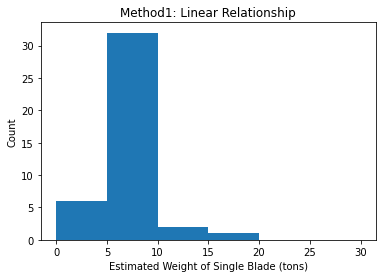

In [6]:
# visualize the distribution of estimated single blade mass
plt.hist(method1_df['est_blade_wt'], bins=[0,5,10,15,20,25,30])  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Estimated Weight of Single Blade (tons)')
plt.title('Method1: Linear Relationship')

In [7]:
print("mean", np.average(method1_df['est_blade_wt']))
print("standard deviation", np.std(method1_df['est_blade_wt']))

mean 6.11149674796748
standard deviation 2.9274347132107614


Text(0.5, 0, 'Turbine Capacity (KW)')

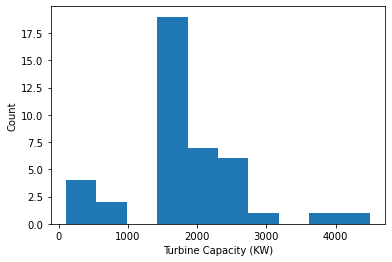

In [8]:
# visualize the distribution of turbine capacity
plt.hist(method1_df['t_cap'])  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Turbine Capacity (KW)')



# Method2: piecewise linear relationship between turbine power and blade mass

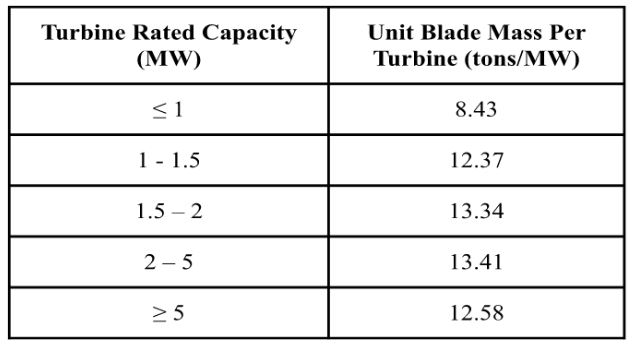


In [9]:
method2_df = grouped_df.assign(cap_mw=lambda df: df.t_cap/1000)
def estimate_blade_mass_piecewise_linear(df):
    cap = df['cap_mw']
    # total blade mass per turbine = ratio * capacity (mw)
    # there are three blades in one turbine 
    if cap <= 1:
        est_blade_mass = 8.43 * cap / 3
    elif (cap > 1) & (cap <= 1.5):
        est_blade_mass = 12.37 * cap / 3
    elif (cap > 1.5) & (cap <= 2):
        est_blade_mass = 13.34 * cap / 3
    elif (cap > 2) & (cap <= 5):
        est_blade_mass = 13.41 * cap / 3
    else:
        assert(cap >= 5)
        est_blade_mass = 12.58 * cap / 3
    return est_blade_mass
method2_df['est_blade_wt'] = method2_df.apply(estimate_blade_mass_piecewise_linear,
                                              axis=1)
method2_df.head()

,t_state,t_county,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,cap_mw,est_blade_wt
0,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,2.200,9.834000
3,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,2.000,8.893333
36,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Nordex,N117/3675,3675.0,91.0,117.0,10751.32,149.4,3.675,16.427250
39,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Siemens Gamesa Renewable Energy,SG-2.625-114,2625.0,93.0,114.0,10207.03,150.0,2.625,11.733750
73,NY,Lewis County,Copenhagen,2018.0,40,80.00,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,2.000,8.893333


Text(0.5, 1.0, 'Method2: Piecewise Linear Relationship')

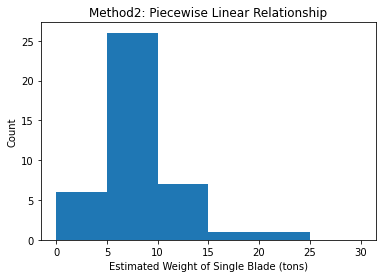

In [10]:
# visualize the distribution of estimated single blade mass
plt.hist(method2_df['est_blade_wt'], bins=[0,5,10,15,20,25,30])  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Estimated Weight of Single Blade (tons)')
plt.title('Method2: Piecewise Linear Relationship')

In [11]:
print("mean", np.average(method2_df['est_blade_wt']))
print("standard deviation", np.std(method2_df['est_blade_wt']))

mean 7.673997560975609
standard deviation 3.996293543589956



# Method3: Exponential relationship between blade mass and rotor radius

In [12]:
method3_df = grouped_df.assign(rotor_radius=lambda df: df.t_rd/2)
def estimate_blade_mass_exp(df):
    # if rator diameter <= 100, baseline model
    if df['t_rd'] <= 100:
        est_blade_mass = 0.1452 * (df['rotor_radius'] ** 2.9158) / 1000
    # if rator diameter > 100, advanced model
    else:
        assert(df['t_rd'] > 100)
        est_blade_mass = 0.4948 * (df['rotor_radius'] ** 2.53) / 1000
    return est_blade_mass
method3_df['est_blade_wt'] = method3_df.apply(estimate_blade_mass_exp, axis=1) 
method3_df.head()

,t_state,t_county,p_name,p_year,p_tnum,p_cap,t_manu,t_model,t_cap,t_hh,t_rd,t_rsa,t_ttlh,rotor_radius,est_blade_wt
0,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2200.0,95.0,110.0,9503.32,150.0,55.0,12.518356
3,NY,Chautauqua County,Arkwright Summit,2018.0,36,78.40,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,55.0,12.518356
36,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Nordex,N117/3675,3675.0,91.0,117.0,10751.32,149.4,58.5,14.633022
39,NY,Chautauqua County,Cassadaga,2021.0,37,125.48,Siemens Gamesa Renewable Energy,SG-2.625-114,2625.0,93.0,114.0,10207.03,150.0,57.0,13.702288
73,NY,Lewis County,Copenhagen,2018.0,40,80.00,Vestas,V110-2.0,2000.0,95.0,110.0,9503.32,150.0,55.0,12.518356


Text(0.5, 1.0, 'Method3: Exponential Relationship')

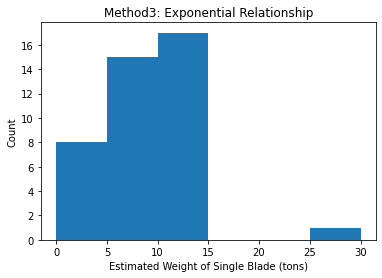

In [13]:
# visualize the distribution of estimated single blade mass
plt.hist(method3_df['est_blade_wt'], bins=[0,5,10,15,20,25,30])  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Estimated Weight of Single Blade (tons)')
plt.title('Method3: Exponential Relationship')

In [14]:
print("mean", np.average(method3_df['est_blade_wt']))
print("standard deviation", np.std(method3_df['est_blade_wt']))

mean 8.52617738001771
standard deviation 4.960131191950212
